In [1]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics
using Flight.FlightComponents
using Flight.FlightAircraft.C172
using Flight.FlightAircraft.C172FBW
using Flight.FlightAircraft.C172FBWMCS

using UnPack
using ControlSystems
using RobustAndOptimalControl
using ComponentArrays
using LinearAlgebra

In [15]:
ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics

design_point = C172.TrimParameters()

#complete longitudinal model
P_lss_lon = Control.Continuous.LinearizedSS(ac, design_point; model = :lon);
P_nss_lon = named_ss(P_lss_lon);

x_labels_lon = keys(P_lss_lon.x0) |> collect
y_labels_lon = keys(P_lss_lon.y0) |> collect
u_labels_lon = keys(P_lss_lon.u0) |> collect
z_labels_lon = [:θ, :EAS] #selected command variables

x_labels = deleteat!(x_labels_lon, findfirst(isequal(:h), x_labels_lon))
y_labels = deleteat!(y_labels_lon, findfirst(isequal(:h), y_labels_lon))
u_labels = u_labels_lon
z_labels = z_labels_lon

#design model
P_lss = Control.Continuous.submodel(P_lss_lon; x = x_labels, u = u_labels, y = y_labels)
P_nss = named_ss(P_lss);

# trim!(ac, design_point)

(success = true, trim_state = [0.023553489660139648, 0.0008930174907698616, 0.8774643019029841, 0.6489929542635975, 0.012480901744149247, -0.2424771622783136, 0.006919022066560567])

## 1. Longitudinal Dynamics Regulator

In [3]:
dampreport(P_nss_lon)
dampreport(P_nss)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+


| -0.000506          |  1            |  0.000506     |  8.05e-05     |  1.98e+03     |


| -0.0192 ±  0.233im |  0.0821       |  0.234        |  0.0373       |  52           |
| -5.55   ±   6.27im |  0.663        |  8.37         |  1.33         |  0.18         |
| -11.7              |  1            |  11.7         |  1.86         |  0.0856       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -47.2              |  1            |  47.2         |  7.51         |  0.0212       |
|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.0195 ±  0.232im |  0.0838       |  0.232        |  0.037        |  51.4         |
| -5.55   ±   6.27im |  0.663        |  8.37         |  1.33         |  0.18         |
| -11.7              |  1            |  11.

We see that removing $h$ as a state eliminates an extremely slow pole, probably related to the effect of altitude on engine output. The remaining poles are virtually unaffected. Also, it significantly improves the condition of the dynamics matrix:

In [4]:
cond(P_nss_lon.A) |> display
cond(P_nss.A) |> display
controllability(P_nss)

1.1890917710031469e8

705827.0717969612

(iscontrollable = true, ranks = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10], sigma_min = [0.004930009072074724, 1.206073227010872, 1.206073227010872, 1.206073227010872, 1.206073227010872, 0.43834219727050705, 0.43362157325950124, 0.43362157325950124, 0.039929081083865205, 0.039929081083865205])

But a much more important reason for removing $h$ is that, even if the dynamics matrix is still invertible, the block $H_x F^{-1} G$ in the feedforward gain matrix required for $\theta$ and $EAS$ tracking is not. This is perfectly understandable: we cannot have an arbitrary combination of $\theta$ and $EAS$ and still maintain constant altitude. In other words, keeping $h$ in the state vector produces quasi-static rather than static equilibrium, and therefore we would need partitioning the state to handle it. Note that this issue is only related to the selection of the command variables $\theta$ and $EAS$, not to the system's dynamics. If we picked instead $h$ and $EAS$, we could have true static equilibrium. Thus, for this design we will use the MIMO system without $h$ as our plant baseline. Let's start by designing a full-state feedback regulator for the MIMO system.

In [5]:
#before proceeding, ensure consistency in component selection and ordering
#between our design model and MCS avionics implementation for state, control and
#command vectors
@assert tuple(x_labels...) === propertynames(C172FBWMCS.XLon())
@assert tuple(u_labels...) === propertynames(C172FBWMCS.ULon())
@assert tuple(z_labels...) === propertynames(C172FBWMCS.ZθEAS())

#some useful signal labels
u_labels_fbk = Symbol.(string.(u_labels) .* "_fbk")
u_labels_fwd = Symbol.(string.(u_labels) .* "_fwd")
z_labels_dmd = Symbol.(string.(z_labels) .* "_dmd")

x_trim = P_lss.x0
u_trim = P_lss.u0
z_trim = P_lss.y0[z_labels]

n_x = length(x_labels)
n_u = length(u_labels)
n_z = length(z_labels)


2

In [6]:
@unpack x0, u0 = P_lss
@unpack v_x, v_z = x0
v_norm = norm([v_x, v_z])

#weight matrices
Q = C172FBWMCS.XLon(q = 1, θ = 5, v_x = 1/v_norm, v_z = 1/v_norm, α_filt = 0, ω_eng = 0, thr_v = 0, thr_p = 0, ele_v = 0, ele_p = 0) |> diagm
R = C172FBWMCS.ULon(throttle_cmd = 1, elevator_cmd = 0.1) |> diagm

#feedback gain matrix
C_fbk = lqr(P_nss, Q, R)
display(C_fbk)

C_fbk_ss = named_ss(ss(C_fbk); u = x_labels, y = u_labels_fbk)

elevator_sum = sumblock("elevator_cmd = elevator_cmd_fwd - elevator_cmd_fbk")
throttle_sum = sumblock("throttle_cmd = throttle_cmd_fwd- throttle_cmd_fbk")
connections = vcat(Pair.(x_labels, x_labels), Pair.(u_labels, u_labels), Pair.(C_fbk_ss.y, C_fbk_ss.y))

P_nss_fbk = connect([elevator_sum, throttle_sum, P_nss, C_fbk_ss], connections; w1 = u_labels_fwd, z1 = vcat(y_labels, u_labels))

dampreport(P_nss) |> display
dampreport(P_nss_fbk) |> display
C_fbk[1, :]'

2×10 Matrix{Float64}:
 0.0324562  -0.56216   0.0767795   0.00818343  …  -3.31639e-5  -0.00286731
 2.59501     9.94617  -0.269466   -0.117464        0.0294353    1.53726

nothing

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.0195 ±  0.232im |  0.0838       |  0.232        |  0.037        |  51.4         |
| -5.55   ±   6.27im |  0.663        |  8.37         |  1.33         |  0.18         |
| -11.7              |  1            |  11.7         |  1.86         |  0.0856       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -47.2              |  1            |  47.2         |  7.51         |  0.0212       |


nothing

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.532  ±   0.35im |  0.836        |  0.637        |  0.101        |  1.88         |
| -8.27              |  1            |  8.27         |  1.32         |  0.121        |
| -11.7              |  1            |  11.7         |  1.86         |  0.0857       |
| -30                |  1            |  30           |  4.78         |  0.0333       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -19.5   ±   33.7im |  0.501        |  38.9         |  6.2          |  0.0512       |
| -46.8              |  1            |  46.8         |  7.45         |  0.0214       |


1×10 adjoint(::Vector{Float64}) with eltype Float64:
 0.0324562  -0.56216  0.0767795  0.00818343  …  -3.31639e-5  -0.00286731

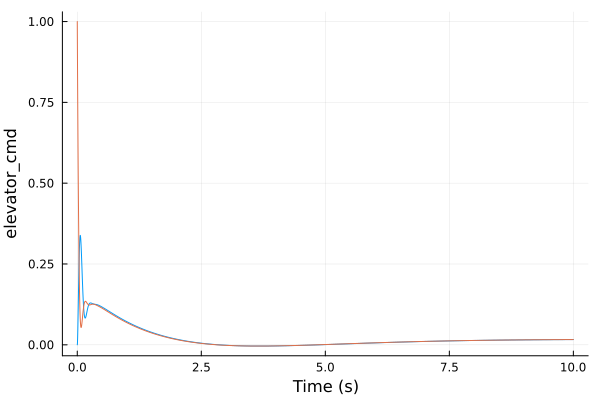

In [7]:
# e2q = P_nss[:q, :elevator_cmd]
# e2q_fbk = P_nss_fbk[:q, :elevator_fwd]
# step(e2q, 10) |> plot
# step(e2q_fbk, 10) |> plot!

# e2θ = P_nss[:θ, :elevator_cmd]
# e2θ_fbk = P_nss_fbk[:θ, :elevator_fwd]
# step(e2θ, 10) |> plot
# step(e2θ_fbk, 10) |> plot!

e2e_fbk = P_nss_fbk[:ele_p, :elevator_cmd_fwd]
e2p_fbk = P_nss_fbk[:elevator_cmd, :elevator_cmd_fwd]
step(e2e_fbk, 10) |> plot
step(e2p_fbk, 10) |> plot!

# t2v_fbk = P_nss_fbk[:EAS, :throttle_fwd]
# t2v_fbk = P_nss_fbk[:EAS, :throttle_fwd]
# t2t_fbk = P_nss_fbk[:throttle_cmd, :throttle_fwd]
# t2θ_fbk = P_nss_fbk[:θ, :throttle_fwd]

# step(t2v, 20) |> plot
# step(t2v_fbk, 20) |> plot
# step(t2t_fbk, 20) |> plot!
# step(t2θ_fbk, 20) |> plot!

## 2. $\theta$ + $EAS$ Tracker

Now, we determine the feedforward gain matrix for tracking $\theta$ and $EAS$. Following Stengel section 6.2:

In [8]:
F = P_lss.A
G = P_lss.B
H_x = P_lss.C[z_labels, :]
H_u = zeros(n_z, n_u)

A = [F G; H_x H_u]
B = inv(A)
B_12 = B[1:n_x, n_x+1:end]
B_22 = B[n_x+1:end, n_x+1:end]
C_fwd = B_22 + C_fbk * B_12
C_fwd_ss = named_ss(ss(C_fwd), u = z_labels_dmd, y = u_labels_fwd)
display(C_fwd)

2×2 Matrix{Float64}:
 4.04034   0.108129
 9.50847  -0.327379

In [9]:
connections = Pair.(C_fwd_ss.y, C_fwd_ss.y)
P_nss_fbk_θv = connect([C_fwd_ss, P_nss_fbk], connections; w1 = z_labels_dmd, z1 = P_nss_fbk.y)

NamedStateSpace{Continuous, Float64}
A = 
    -5.087133374044791      -4.163297421103107e-6     0.07439014250546266     -3.855196994002445        147.75243672598165     0.0037052261137903875    0.0                     0.0                  0.0                     14.004653905006602
     0.9999996012599071     -1.544910167889241e-13    1.5777313884823625e-7    3.7167544011749594e-9      0.0                  0.0                      0.0                     0.0                  0.0                      0.0
     1.8618423333210217     -9.77447255571633        -0.13232563638971148      2.444234981883577        -90.97971002329461     0.018752867290564558     0.0                     0.0                  0.0                     -8.022244361468097
    51.03453184524183       -0.2302587094682984      -0.2990194687201938      -3.1345841988293373        32.581572161098734    6.2053375588087e-5       0.0                     0.0                  0.0                      4.95596084827368
     0.0     

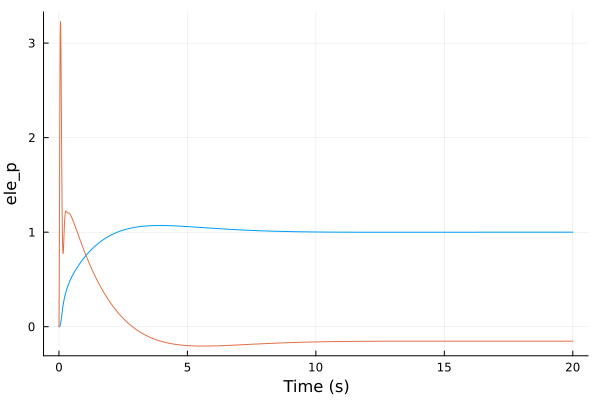

In [10]:
θdmd2θ = P_nss_fbk_θv[:θ, :θ_dmd]
θdmd2e = P_nss_fbk_θv[:ele_p, :θ_dmd]
step(θdmd2θ, 20) |> plot
step(θdmd2e, 20) |> plot!

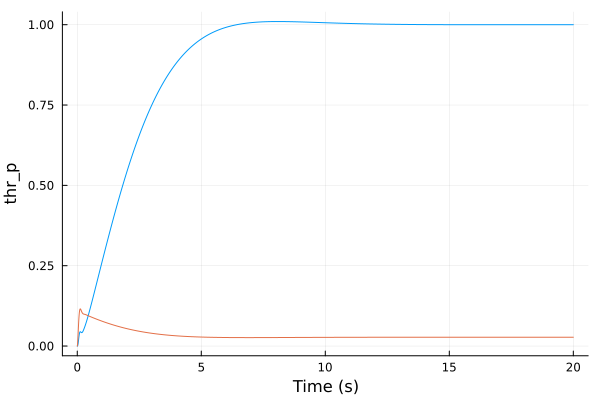

In [11]:
vdmd2v = P_nss_fbk_θv[:EAS, :EAS_dmd]
vdmd2t = P_nss_fbk_θv[:thr_p, :EAS_dmd]
step(vdmd2v, 20) |> plot
step(vdmd2t, 20) |> plot!

## 3. Pitch Rate Tracker

Now, on top of the $\theta$ + $EAS$ tracker we can provide a pitch rate tracker by adding an integrator upstream of the $\theta_{dmd}$ input:

In [12]:
q_int = tf(1, [1, 0])
q_ff = named_ss(q_int |> ss, u = :q_dmd, y = :θ_dmd)
P_nss_fbk_qv = connect([q_ff, P_nss_fbk_θv], [:θ_dmd => :θ_dmd]; w1 = [:q_dmd, :EAS_dmd], z1 = P_nss_fbk_θv.y)
qdmd2q = P_nss_fbk_qv[:q, :q_dmd];

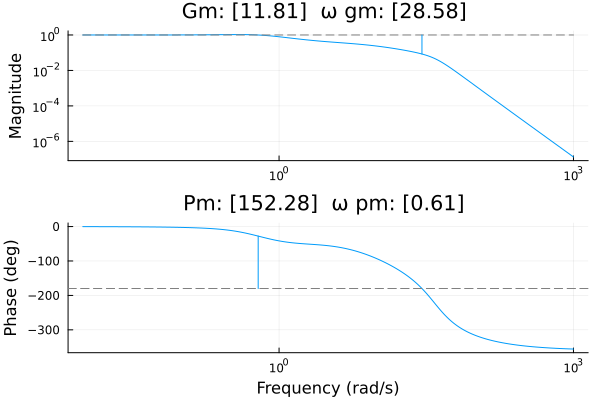

In [13]:
marginplot(qdmd2q)

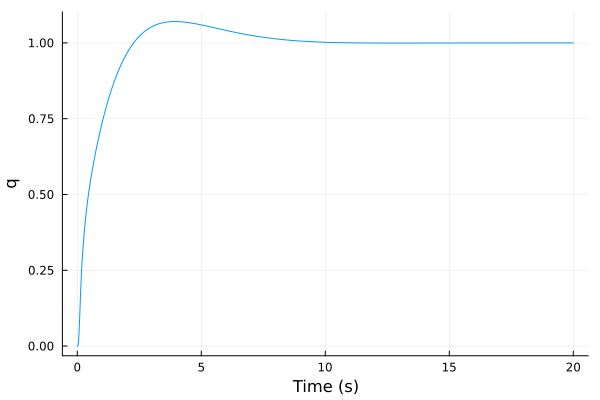

In [14]:
step(qdmd2q, 20) |> plot

In the actual implementation, $\dot{\theta}$ should not be computed directly as $\dot{\theta} = q_{dmd}$ but through the kinematic relation:
$$ q(\dot{\theta}, r, \phi) = \dfrac{1}{\cos \phi}(\dot{\theta} + r \tan \phi) $$
$$ \dot{\theta}_{dmd} = q_{dmd} \cos \phi - r \tan \phi$$